# Source Code Notebook - DenseNet


## Image Conversion and Validation


### Conversion of JPG to JPEG

```
pip install opencv-python
```


In [23]:
# installations
# %pip install matplotlib
# %pip install numpy
# %pip install tensorflow
# %pip install opencv-python

In [24]:
import cv2
import os
from pathlib import Path
DATA_DIR = "dataset/AI Art vs Real Art/" # Put unzipped files to the unzipped folder and change accordingly

def jpg_to_jpeg(data_dir):
    for dir_name in os.listdir(data_dir):
        files = os.path.join(data_dir,dir_name)
        for filepaths in os.listdir(files):
            file_names = os.path.join(files,filepaths)
            if file_names.endswith(".jpg") or file_names.endswith(".JPG"):
                img = cv2.imread(str(file_names))
                cv2.imwrite(file_names[0:-4]+".jpeg", img)
                os.remove(file_names)

### Checking of the validity of Images in the dataset


In [25]:
import imghdr

IMAGE_EXTENSIONS = [".png", ".jpg", ".jpeg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(DATA_DIR).rglob("*"):
    if filepath.suffix.lower() in IMAGE_EXTENSIONS:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

## Data Preprocessing


### Import Tensorflow and Keras and check on available GPU


In [26]:
import sys
import tensorflow as tf
import keras
import platform
import numpy as np

print(f"Python Platform: {platform.version()}")
print(f"Python Version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print(f"GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: 10.0.22621
Python Version: 3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 64 bit (AMD64)]
Tensorflow version: 2.16.1
Keras version: 3.2.0

GPU is NOT AVAILABLE


### Set constants for Images


In [27]:
BATCH_SIZE = 32
HEIGHT = 240
WIDTH = 240
IMAGE_SIZE = (HEIGHT, WIDTH)

### Use Keras' Preprocessing modules to split data


In [28]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
    label_mode='binary',
    labels='inferred',
    color_mode='rgb',
    directory=DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=1337,
    validation_split=0.2,
    subset="training",
    verbose=True,
)

val_dataset = keras.preprocessing.image_dataset_from_directory(
    label_mode='binary',
    labels='inferred',
    color_mode='rgb',
    directory=DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=1337,
    validation_split=0.2, # use 20% as validation
    subset="validation",
    verbose=True,
)

# The target labels
class_names = train_dataset.class_names
print(class_names)

Found 912 files belonging to 2 classes.
Using 730 files for training.
Found 912 files belonging to 2 classes.
Using 182 files for validation.
['AI Art', 'Real']


### Display Sample Images


In [29]:
import matplotlib.pyplot as plt

# def display_binary_images(dataset, class_names):
#     plt.figure(figsize=(10, 10))
#     for images, labels in dataset.take(1):
#         for i in range(9):
#             ax = plt.subplot(3, 3, i + 1)
#             plt.imshow(images[i].numpy().astype("uint8"))
#             plt.title(class_names[int(labels[i].numpy())])
#             plt.axis("off")

# display_binary_images(train_dataset, class_names)

### Data Augmentation

In [30]:
augmentation_layers = [
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

## Importing EfficientNetB4


In [31]:
from tensorflow.keras.applications import EfficientNetB1
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import layers, Model

Impot EfficientNetB4 as base model

Fine-Tuning the model

Step decay scheduler

In [32]:
from tensorflow.keras.callbacks import LearningRateScheduler

def step_decay_scheduler(epoch, lr):
    initial_lr = 0.0001
    drop_rate = 0.25
    epochs_drop = 7

    if epoch>= epochs_drop:
        lr *= drop_rate

    return lr

Early stopping

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

stop = EarlyStopping(
    monitor='val_loss',
    patience=9,
    restore_best_weights=True
)

In [34]:
base_model = EfficientNetB1(
    include_top=False, 
    weights="imagenet",
    input_shape=(HEIGHT,WIDTH, 3),
)

In [35]:
from tensorflow.keras import regularizers

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

In [36]:
model = Model(inputs=base_model.input, outputs=x)

initial_lr = 0.001
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=initial_lr),
    loss='binary_crossentropy',
    metrics=[keras.metrics.BinaryAccuracy()]
)

step_decay_scheduler = LearningRateScheduler(step_decay_scheduler)
# model.summary()

Training the Model

In [37]:
EPOCHS = 50

tuned_model = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[step_decay_scheduler, stop]
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 220s 7s/step - binary_accuracy: 0.6468 - loss: 0.6356 - val_binary_accuracy: 0.6484 - val_loss: 1.0946 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 145s 6s/step - binary_accuracy: 0.8373 - loss: 0.4084 - val_binary_accuracy: 0.8077 - val_loss: 0.6449 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 153s 7s/step - binary_accuracy: 0.8860 - loss: 0.3129 - val_binary_accuracy: 0.7637 - val_loss: 1.1054 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 155s 7s/step - binary_accuracy: 0.9165 - loss: 0.2263 - val_binary_accuracy: 0.8132 - val_loss: 0.9641 - learning_rate: 0.0010
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 155s 7s/step - binary_accuracy: 0.9011 - loss: 0.2696 - val_binary_accuracy: 0.7912 - val_loss: 1.2536 - learning_rate: 0.0010
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 149s 6s/step - binary_accuracy: 0.9599 - loss: 0.1377 - val_binary_accuracy: 0.7912 - val_loss: 0.8873 - learning_rate: 0.0010
Epoch 7/50

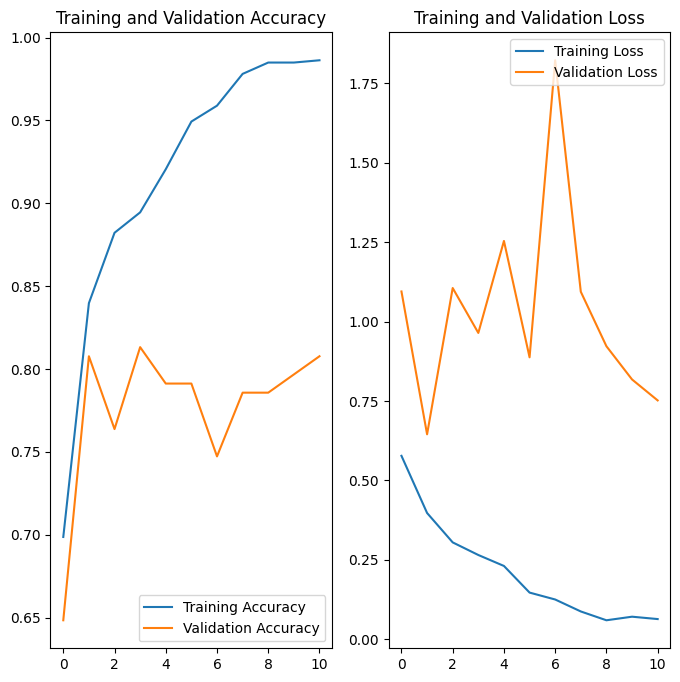

In [38]:
acc = tuned_model.history['binary_accuracy']
val_acc = tuned_model.history['val_binary_accuracy']
#
loss = tuned_model.history['loss']
val_loss = tuned_model.history['val_loss']
if stop.stopped_epoch != 0:
    epochs_range = range(stop.stopped_epoch+1)
else:
    epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()